In **Part 1**, the compression algorithm used in the data historian was described. This post (**Part 2**) illustrates the consequences of improperly preprocessing data from the historian. Compressed, *raw* data from the historian cannot be treated as *randomly sampled* data, as the sampling is non-randomly skewed towards less common values. 

A stochastic state simulation was developed to imitate typical sensor behavior, with each state corresponding to a sensor value. To reduce complexity, the simulation assumes the Markov property, where the state transition probability depends only on the current state (memoryless). The simulation contains 11 possible states and is intended to model a relatively stationary signal with an overall tendency towards state 5 (zero-indexed).

As an aside, why not randomly sample from a normal distribution, rather than develop the Markov simulation described above? In this situation, random sampling would not adequately match the real-world sensor behavior being modeled. When randomly sampling data, it is less likely that subsequent data points have exactly the same value, compared to the Markov simulation. Signals may have low resolution (e.g. temperature) or are controlled (e.g. load), and a Markov simulation ends up a better approximation of the actual dataset.

The following code defines the Markov Chain matrix. In the MC matrix, rows refer to the current state and columns to the subsequent state, with the cell value defining the probability for the transition. For instance, if the current state is 2, the probability to transition to state 3 may be found in cell{2,3}.

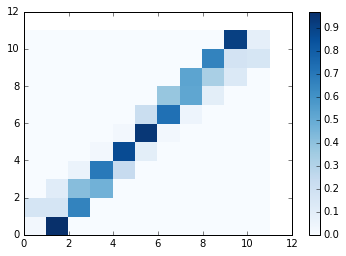

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#Construct the Markov Chain array. For ease of visualization, all cells
#have two decimal places.
mC = np.array([[0.03,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                [0.17,0.17,0.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                [0.00,0.11,0.42,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
                [0.00,0.00,0.06,0.70,0.24,0.00,0.00,0.00,0.00,0.00,0.00],
                [0.00,0.00,0.00,0.03,0.87,0.10,0.00,0.00,0.00,0.00,0.00],
                [0.00,0.00,0.00,0.00,0.03,0.94,0.03,0.00,0.00,0.00,0.00],
                [0.00,0.00,0.00,0.00,0.00,0.22,0.73,0.05,0.00,0.00,0.00],
                [0.00,0.00,0.00,0.00,0.00,0.00,0.38,0.52,0.10,0.00,0.00],
                [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.53,0.33,0.14,0.00],
                [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.66,0.18,0.16],
                [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.91,0.09]])
#Plot a heatmap of the Markov Chain
plt.figure(0)
hm = plt.pcolor(mC,cmap='Blues');
plt.colorbar(hm);

The heatmap above visualizes the Markov Chain matrix, generated from an approximation of a real temperature sensor, under the constraint that transitioning more than 2 states away per iteration is impossible, as all cell values more than 1 step away from the current state (the diagonal) are zero. 

The following code performs the stochastic Markov Chain simulation for a total of 100000 time steps, using 5 as the initial state. First, the *"true"* time-series array is obtained through random walk, and then the *"raw"* time-series array is reproduced by iterating through the *"true"* array and running the compression algorithm.

In [2]:
import random
#Finding the cumulative sum means that we can draw a random number 
#between 0 to 1, iterate through each state, and check if the 
#random number is less than the cell value to determine which 
#state transition occurs.
mCS = np.cumsum(mC,axis=1)
#Initialization
curState = 5
trueStates = [5]
#Iterate over a total of 100,000 time steps
for ii in range(100000):    
    rn = random.random()
    #Iterate all possible states to find the state transition
    for jj in range(11):
        if (rn < mCS[curState,jj]):
            curState = jj
            break
    #Save the current state to an array      
    trueStates.append(curState)
#Now, work backwards to "compress" the data so it matches the 
#historian algorithm
prevState = 5   
rawStates = [5]
for ii in range(1,len(trueStates)):
    ts = trueStates[ii]
    if (prevState == ts):
        rawStates.append(None)
    else:
        rawStates[ii-1] = prevState
        rawStates.append(ts)
        prevState = ts

The following code compares the results from the simulation by plotting the two distributions, *"true"* and *"raw"*. As can be seen from the figure below, the distributions look very different. The "Raw States" distribution has a significantly different shape than the "True States" distribution and an increased standard deviation, which will adversely affect model performance.

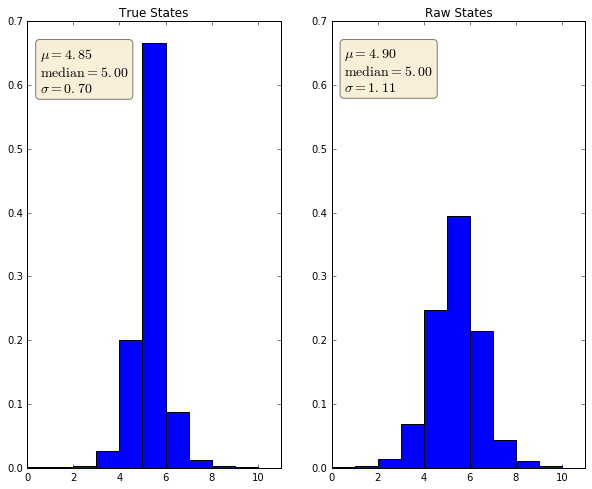

In [3]:
from scipy.stats import kurtosis
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#Remove the None values from the rawStates
rawStatesR = [ii for ii in rawStates if ii is not None]
#Generate text boxes containing the mean and std
txtT = '$\mu=%.2f$\n$\mathrm{median}=%.2f$\n$\sigma=%.2f$'%\
    (np.mean(trueStates),np.median(trueStates),np.std(trueStates))
txtR = '$\mu=%.2f$\n$\mathrm{median}=%.2f$\n$\sigma=%.2f$'%\
    (np.mean(rawStatesR),np.median(rawStatesR),np.std(rawStatesR))
#Plot using matplotlib
plt.figure(1, figsize=[10,8])
ax = plt.subplot(1,2,1)
plt.hist(trueStates,normed=1);
ax.text(0.05, 0.95, txtT, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('True States')
plt.axis([0,11,0,0.7])
ax = plt.subplot(1,2,2)
plt.hist(rawStatesR,normed=1);
ax.text(0.05, 0.95, txtR, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('Raw States')
plt.axis([0,11,0,0.7]);

In summary, it was shown that retrieving compressed data from the historian without expanding it back to its original form does have a significant effect on the shape of the data distribution.